
# Stratification made easy
When stratifying model $A$ with model $B$, there is some confusion about seemingly spurious transitions that must be added to $A$ and $B$ in order to get a desired result. This notebook aims to clear some of the confusion and show a simple function can wrap around Catlab's "product of models" functionality allow an end user to control this process in an intuitive way.

### Example models


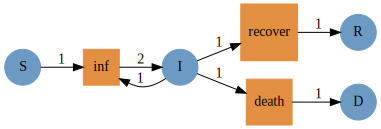

In [1]:

using Catlab, Catlab.CategoricalAlgebra
using AlgebraicPetri

SIRD = LabelledPetriNet([:S, :I, :R, :D],
    :inf => ((:S,:I) => (:I,:I)),
    :recover => (:I=>:R),
    :death => (:I=>:D))


Graph(SIRD)


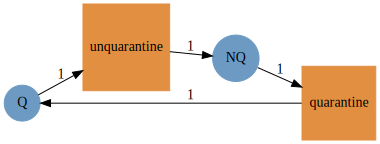

In [2]:
Quarantine = LabelledPetriNet([:Q,:NQ],
    :quarantine => ((:NQ)=>(:Q)),
    :unquarantine => ((:Q)=>(:NQ)))

Graph(Quarantine)

Stratification implicitly depends on assigning "types" to each of the elements of the model, which controls how the product is taken. We consider three types of transitions:
- infection transitions between two individuals 
- an individual changing disease state
- an individual change strata

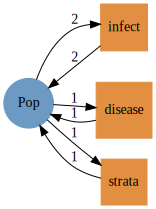

In [3]:
types′ = LabelledPetriNet([:Pop],
    :infect=>((:Pop, :Pop)=>(:Pop, :Pop)),
    :disease=>(:Pop=>:Pop),
    :strata=>(:Pop=>:Pop))
types = map(types′, Name=name->nothing) # names only needed for visualization
Graph(types′)

Here we assign types (i.e. pick a homomorphism from our models into `types`) and perform stratification using a `pullback`.

In [4]:
SIRD_typed = homomorphism(SIRD, types;
    initial=(T=[1,2,2],I=[1,2,3,3],O=[1,2,3,3]),
    type_components=(Name=x->nothing,))

Quarantine_typed = homomorphism(Quarantine, types;
    initial=(T=[3,3],), type_components=(Name=x->nothing,))

naive_stratification = apex(pullback(SIRD_typed, Quarantine_typed))
nt(naive_stratification) # number of transitions is 0 ... not what we want!

0

There's an obvious problem here! Because we took a product without any cross terms, we effectively are multiplying the transitions in `SIR` with "0" and likewise for the transitions in `Quarantine`. This won't make sense to an end user, though. A user-friendly way of exposing these cross terms is to say: given the SIR model, what kinds of transitions (from the *other* model) do you want the different states to be able to perform?

For `SIR`, the other model is `Quarantine` which has only one kind of transition. So we decide for `S`,`I`,`R`,`D` whether or not we think that population should be able to change strata. (my answer: yes, yes, yes, no).

Likewise, for `Quarantine`, we decide for `Q` and `NQ` whether or not we want to allow disease state changes *and* whether or not we want to allow infection to occur. The modeler might decide that both populations can change disease state (e.g. recover or die) but only the `NQ` group can get infected.

In [5]:
"""Modify a typed petri net to add cross terms"""
function add_cross_terms(pn_crossterms, type_system)
  typed_pn, crossterms = deepcopy.(pn_crossterms)
  pn = dom(typed_pn)
  type_comps = Dict([k=>collect(v) for (k,v) in pairs(components(typed_pn))])
  for (s_i,cts) in enumerate(crossterms)
    for ct in cts 
      type_ind = findfirst(==(ct), type_system[:tname])
      is, os = [incident(type_system, type_ind, f) for f in [:it, :ot]]
      new_t = add_part!(pn, :T; tname=ct)
      add_parts!(pn, :I, length(is); is=s_i, it=new_t)
      add_parts!(pn, :O, length(os); os=s_i, ot=new_t)
      push!(type_comps[:T], type_ind)
      append!(type_comps[:I], is); append!(type_comps[:O], os); 
    end
  end
  return homomorphism(pn, codom(typed_pn); initial=type_comps, 
                      type_components=(Name=x->nothing,),)
end

"""Add cross terms before taking pullback"""
function stratify(pn1, pn2, type_system)
  return pullback([add_cross_terms(pn, type_system) for pn in [pn1, pn2]]) |> apex
end



stratify

With those helper functions out of the way, here is what the modeler would have to write

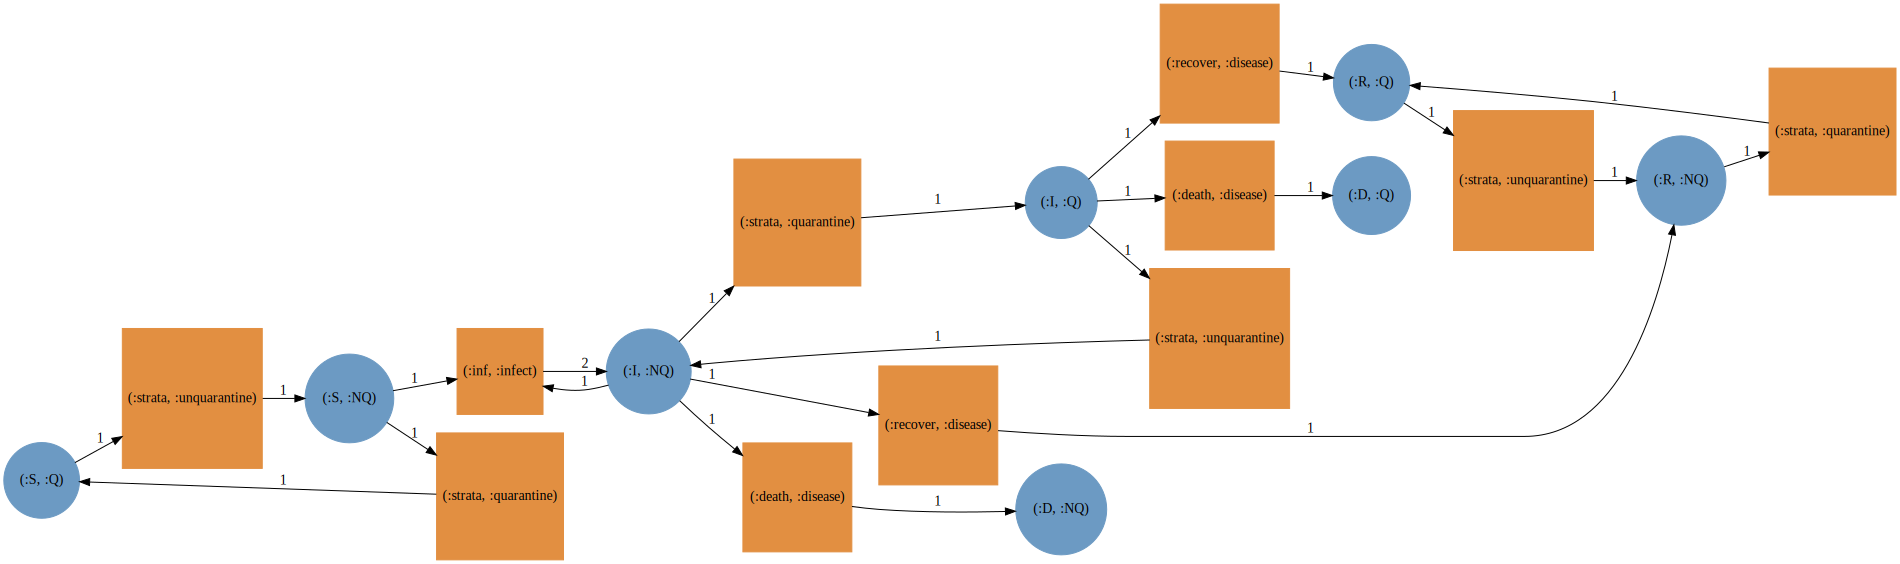

In [6]:
res = stratify(SIRD_typed=>[[:strata],[:strata],[:strata],[]], # S I R D
               Quarantine_typed=>[[:disease], [:disease,:infect]],# Q NQ 
               types′) 
Graph(res)


Or, we may want to assume all cross terms exist by default and just specify which transitions are forbidden.

In [7]:
function stratify_except(pn1, pn2, type_system)
  cross1, cross2 = map([pn1=>pn2,pn2=>pn1]) do (pn, other) 
    map(parts(dom(pn[1]),:S)) do s 
      setdiff(type_system[other[1][:T]|>collect,:tname], get(Dict(pn[2]), s, []))
    end
  end
  stratify(pn1[1]=>cross1,pn2[1]=>cross2, type_system)
end

res2 = stratify_except(SIRD_typed=>[4=>[:strata]], 
                       Quarantine_typed=>[1=>[:infect]], types′)

is_isomorphic(res, res2) # same result

true

Our final result is a model with quarantined and unquarantined people who may be susceptible, infected, recovered, or dead. By high-level construction, we've forbidden the possibility of quarantined people from participating in infection as well as the dead population changing quarantine status.